# HMDA Exploratory Data Analysis

## Setup
-----

In [6]:
import gzip
import os
import requests
import subprocess
from pathlib import Path

import pandas as pd
import numpy as np
import scipy.stats as stats

# supporting code
from hmda_lib import valid_state_codes
from hmda_lib import valid_years
from hmda_lib import county_data
from hmda_lib import label_dict

# data visualizations
import hvplot.pandas
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
def download_hmda_data(fd, state, year):
    url = f'https://ffiec.cfpb.gov/v2/data-browser-api/view/csv?states={state}&years={year}'

    try:
        with requests.get(url, stream=True) as response:
            response.raise_for_status()
            with open(output_file, 'wb') as fd:
                for chunk in response.iter_content(chunk_size=1024):
                    if chunk:
                        fd.write(chunk)
        return True

    except requests.exceptions.RequestException as e:
        print(f"Error downloading data: {e}")
        return False

In [8]:
def compress_hmda_data(f):
    subprocess.run(['gzip', f])    

## Data Processing
-----

### Data Collection

In [9]:
# download HMDA data from API

state = 'MN'
years = ['2018', '2019', '2020', '2021', '2022']

for year in years:
    output_file = Path('hmda_data', f'hmda-{state}-{year}.csv')
    if os.path.exists(f'{output_file}.gz'):
        print('File exists already! Skipping!')
        continue
    else:
        print(f'Downloading HMDA data for: {year} {state}.....', end='')
        download_hmda_data(output_file, state, year)
        print(' compressing.....', end='')
        compress_hmda_data(output_file)
        print(' done!')

File exists already! Skipping!
File exists already! Skipping!
File exists already! Skipping!
File exists already! Skipping!
File exists already! Skipping!


In [10]:
# load the HMDA data into Pandas DataFrames

data_path = 'hmda_data'
filenames = os.listdir(data_path)
all_dataframes = []

for filename in filenames:
    if filename.endswith('.csv.gz'):
        filepath = Path(data_path, filename)
        with gzip.open(filepath, 'rt') as file:
            df = pd.read_csv(filepath)
        all_dataframes.append(df)

unclean_df = pd.concat(all_dataframes, ignore_index=True)

/tmp/ipykernel_15187/2038427819.py:11: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/tmp/ipykernel_15187/2038427819.py:11: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/tmp/ipykernel_15187/2038427819.py:11: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/tmp/ipykernel_15187/2038427819.py:11: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/tmp/ipykernel_15187/2038427819.py:11: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types. Specify dtype option on import or set low_mem

### Data Cleaning

In [11]:
# remove null values and 'Exempt' interest rate from dataframe

df = unclean_df[unclean_df['interest_rate'].notnull()]
df = df.query('interest_rate != "Exempt"')
df = df.query('loan_to_value_ratio != "Exempt"')

In [12]:
# remove null loan terms from dataframe

df = df[df['loan_term'].notnull()]

In [13]:
# data type conversions

df['interest_rate'] = pd.to_numeric(df['interest_rate'], errors='raise')
df['loan_to_value_ratio'] = pd.to_numeric(df['loan_to_value_ratio'], errors='raise')

In [14]:
# rename values

df['derived_race'] = df['derived_race'].replace({
    'Black or African American': 'Black',
    'American Indian or Alaska Native': 'Native',
    'Native Hawaiian or Other Pacific Islander': 'Pacific Islander'
})

In [15]:
# drop lending institutions that have low application counts

df['lei'].value_counts()

lei
6BYL5QZYBDK8S7L73M02    117008
KB1H1DSPRFMYMCUFXT09     90161
549300WYBPIWKK6SQC06     56778
549300FGXN1K3HLB1R50     55076
549300HW662MN1WU8550     33033
                         ...  
5493008ICL5D7TS4CI35         1
549300AX5UMUZ61L1X54         1
5493003H8ECZKN77IZ88         1
549300UL36AJZ0WZ4U93         1
549300214PKB2Y1ZWH75         1
Name: count, Length: 1018, dtype: int64

## Data Exploration
-----

In [22]:
df['county_code'].value_counts()

county_code
27053.0    311846
27037.0    121816
27123.0    106889
27003.0    103154
27163.0     81346
            ...  
55113.0         1
29095.0         1
46099.0         1
38017.0         1
6037.0          1
Name: count, Length: 111, dtype: int64

In [21]:
df

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
1,2020,AD6GFRVSDT01YPT1CS68,33460,MN,27123.0,2.712304e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4366,38.91,97300,71,750,878,50
2,2020,AD6GFRVSDT01YPT1CS68,33460,MN,27053.0,2.705303e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3248,8.68,97300,138,1147,1246,49
3,2020,AD6GFRVSDT01YPT1CS68,33460,MN,27163.0,2.716307e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3995,9.31,97300,103,1367,1741,38
4,2020,AD6GFRVSDT01YPT1CS68,99999,MN,27035.0,2.703595e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,1910,1.20,70900,90,843,2542,33
5,2020,AD6GFRVSDT01YPT1CS68,33460,MN,27139.0,2.713908e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,7709,20.08,97300,158,2415,2818,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1787487,2021,593C3GZG957YOJPS2Z63,33460,MN,27053.0,2.705311e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3706,38.96,100600,78,903,1162,76
1787488,2021,593C3GZG957YOJPS2Z63,33460,MN,27053.0,2.705302e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,5901,55.28,100600,75,588,1006,40
1787489,2021,593C3GZG957YOJPS2Z63,33460,MN,27053.0,2.705311e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,2805,32.94,100600,81,931,1146,76
1787490,2021,593C3GZG957YOJPS2Z63,33460,MN,27053.0,2.705302e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,3891,26.70,100600,75,1207,1365,61


In [24]:
for c in df.columns:
    print(c)

activity_year
lei
derived_msa-md
state_code
county_code
census_tract
conforming_loan_limit
derived_loan_product_type
derived_dwelling_category
derived_ethnicity
derived_race
derived_sex
action_taken
purchaser_type
preapproval
loan_type
loan_purpose
lien_status
reverse_mortgage
open-end_line_of_credit
business_or_commercial_purpose
loan_amount
loan_to_value_ratio
interest_rate
rate_spread
hoepa_status
total_loan_costs
total_points_and_fees
origination_charges
discount_points
lender_credits
loan_term
prepayment_penalty_term
intro_rate_period
negative_amortization
interest_only_payment
balloon_payment
other_nonamortizing_features
property_value
construction_method
occupancy_type
manufactured_home_secured_property_type
manufactured_home_land_property_interest
total_units
multifamily_affordable_units
income
debt_to_income_ratio
applicant_credit_score_type
co-applicant_credit_score_type
applicant_ethnicity-1
applicant_ethnicity-2
applicant_ethnicity-3
applicant_ethnicity-4
applicant_ethnicit

In [25]:
for c in df.columns:
    print(f'Examining column: {c}')
    print(df[c].value_counts())
    print()

Examining column: activity_year
activity_year
2020    352175
2021    340417
2019    226539
2018    188313
2022    171579
Name: count, dtype: int64

Examining column: lei
lei
6BYL5QZYBDK8S7L73M02    117008
KB1H1DSPRFMYMCUFXT09     90161
549300WYBPIWKK6SQC06     56778
549300FGXN1K3HLB1R50     55076
549300HW662MN1WU8550     33033
                         ...  
5493008ICL5D7TS4CI35         1
549300AX5UMUZ61L1X54         1
5493003H8ECZKN77IZ88         1
549300UL36AJZ0WZ4U93         1
549300214PKB2Y1ZWH75         1
Name: count, Length: 1018, dtype: int64

Examining column: derived_msa-md
derived_msa-md
33460    922913
99999    194118
40340     46655
20260     40437
41060     37052
22020     14455
31860     13873
24220      4538
29100      3301
0          1662
38060         3
36084         2
32580         1
36100         1
39580         1
38940         1
19740         1
23580         1
12980         1
47300         1
36740         1
16974         1
41700         1
28140         1
43620       

In [26]:
df['derived_race'].value_counts()

derived_race
White                       882643
Race Not Available          288832
Asian                        47390
Black                        30486
Joint                        23764
Native                        3857
Pacific Islander              1106
2 or more minority races       879
Free Form Text Only             66
Name: count, dtype: int64

## Statistics
-----

### Statistics Summaries

In [27]:
loan_amount_mean = df['loan_amount'].mean()
loan_amount_median = df['loan_amount'].median()
loan_amount_std = df['loan_amount'].std()

interest_rate_mean = df['interest_rate'].mean()
interest_rate_median = df['interest_rate'].median()
interest_rate_std = df['interest_rate'].std()

ltv_mean = df['loan_to_value_ratio'].mean()
ltv_median = df['loan_to_value_ratio'].median()
ltv_std = df['loan_to_value_ratio'].std()

print("Loan Amount")
print(f"\tMean: {loan_amount_mean:.2f}")
print(f"\tMedian: {loan_amount_median:.2f}")
print(f"\tStandard Deviation: {loan_amount_std:.2f}")
print()
print("Interest Rate")
print(f"\tMean: {interest_rate_mean:.2f}")
print(f"\tMedian: {interest_rate_median:.2f}")
print(f"\tStandard Deviation: {interest_rate_std:.2f}")
print()
print("Loan-to-Value Ratio")
print(f"\tMean: {ltv_mean:.2f}")
print(f"\tMedian: {ltv_median:.2f}")
print(f"\tStandard Deviation: {ltv_std:.2f}")

Loan Amount
	Mean: 248359.20
	Median: 215000.00
	Standard Deviation: 615881.56

Interest Rate
	Mean: 3.84
	Median: 3.50
	Standard Deviation: 11.84

Loan-to-Value Ratio
	Mean: 94.38
	Median: 79.90
	Standard Deviation: 17728.51


In [28]:
# Statistics Summary Table - Interest Rates by Race
race_group = df.groupby('derived_race')

summary_table = pd.DataFrame({
    "Mean Interest Rate": race_group['interest_rate'].mean(),
    "Median Interest Rate": race_group['interest_rate'].median(),
    "Interest Rate Variance": race_group['interest_rate'].var(),
    "Interest Rate Std. Dev.": race_group['interest_rate'].std(),
    "Interest Rate Std. Err.": race_group['interest_rate'].sem()
})

summary_table

,Mean Interest Rate,Median Interest Rate,Interest Rate Variance,Interest Rate Std. Dev.,Interest Rate Std. Err.
derived_race,,,,,
2 or more minority races,3.947778,3.625,2.205659,1.485146,0.050093
Asian,3.687475,3.375,1.426056,1.194176,0.005486
Black,3.820617,3.500,10.695898,3.270458,0.018731
Free Form Text Only,4.121212,3.750,2.153253,1.467397,0.180624
Joint,3.803048,3.500,1.382663,1.175867,0.007628
Native,3.943490,3.625,2.024991,1.423022,0.022913
Pacific Islander,3.903947,3.625,1.771620,1.331022,0.040023
Race Not Available,4.013744,3.625,425.640704,20.631062,0.038388
White,3.788169,3.500,63.506752,7.969112,0.008482


In [29]:
# Statistics Summary Table - Loan Amount by Race
race_group = df.groupby('derived_race')

summary_table = pd.DataFrame({
    "Mean Loan Amount": race_group['loan_amount'].mean(),
    "Median Loan Amount": race_group['loan_amount'].median(),
    "Loan Amount Variance": race_group['loan_amount'].var(),
    "Loan Amount Std. Dev.": race_group['loan_amount'].std(),
    "Loan Amount Std. Err.": race_group['loan_amount'].sem()
})

summary_table

,Mean Loan Amount,Median Loan Amount,Loan Amount Variance,Loan Amount Std. Dev.,Loan Amount Std. Err.
derived_race,,,,,
2 or more minority races,222792.946530,215000.0,1.509763e+10,1.228724e+05,4144.383518
Asian,259132.306394,245000.0,2.159910e+10,1.469663e+05,675.109934
Black,233876.533491,225000.0,1.672560e+10,1.293275e+05,740.697008
Free Form Text Only,177121.212121,160000.0,1.914005e+10,1.383476e+05,17029.407105
Joint,263156.455142,245000.0,3.046722e+10,1.745486e+05,1132.287305
Native,202814.363495,185000.0,1.710770e+10,1.307964e+05,2106.060973
Pacific Islander,188860.759494,165000.0,1.275095e+11,3.570847e+05,10737.266542
Race Not Available,299401.347496,225000.0,1.590348e+12,1.261090e+06,2346.515169
White,231484.173103,205000.0,2.525568e+10,1.589203e+05,169.155828


In [30]:
# Statistics Summary Table - loan_to_value_ratio by Race
race_group = df.groupby('derived_race')

summary_table = pd.DataFrame({
    "Mean Loan to Value Ratio": race_group['loan_to_value_ratio'].mean(),
    "Median Loan to Value Ratio": race_group['loan_to_value_ratio'].median(),
    "Loan to Value Ratio Variance": race_group['loan_to_value_ratio'].var(),
    "Loan to Value Ratio Std. Dev.": race_group['loan_to_value_ratio'].std(),
    "Loan to Value Ratio Std. Err.": race_group['loan_to_value_ratio'].sem()
})

summary_table

,Mean Loan to Value Ratio,Median Loan to Value Ratio,Loan to Value Ratio Variance,Loan to Value Ratio Std. Dev.,Loan to Value Ratio Std. Err.
derived_race,,,,,
2 or more minority races,83.870818,90.0000,3.262467e+02,18.062301,0.639399
Asian,78.711334,80.0000,3.321952e+02,18.226223,0.087076
Black,84.992076,90.0010,3.088362e+02,17.573736,0.105730
Free Form Text Only,74.098766,79.6150,4.812053e+02,21.936393,2.742049
Joint,77.881710,80.0000,3.260366e+02,18.056485,0.121906
Native,80.468634,81.8750,3.725801e+02,19.302335,0.328339
Pacific Islander,76.671769,79.9615,4.062736e+02,20.156230,0.634233
Race Not Available,73.672802,77.0000,3.634651e+02,19.064760,0.053932
White,99.269989,79.7640,4.009625e+08,20024.049157,22.232933


In [31]:
# Statistics Summary Table - interest_rate by lending institute
lei_group = df.groupby('lei')

summary_table = pd.DataFrame({
    "Mean Interest Rate": lei_group['interest_rate'].mean(),
    "Median Interest Rate": lei_group['interest_rate'].median(),
    "Interest Rate Variance": lei_group['interest_rate'].var(),
    "Interest Rate Std. Dev.": lei_group['interest_rate'].std(),
    "Interest Rate Std. Err.": lei_group['interest_rate'].sem()
})

summary_table

,Mean Interest Rate,Median Interest Rate,Interest Rate Variance,Interest Rate Std. Dev.,Interest Rate Std. Err.
lei,,,,,
0K2D5AK28E3O5CC06E35,3.171875,3.1250,0.355990,0.596649,0.149162
0L0W72STJN2EGP1X2N39,4.733742,4.7500,0.749633,0.865813,0.027872
0S8H5NJFLHEVJXVTQ413,3.375000,3.3750,0.031250,0.176777,0.125000
1DU7IM20QESYGDO4HO54,3.792500,4.3200,2.779692,1.667241,0.833620
1IE8VN30JCEQV1H4R804,3.630800,3.5760,0.761900,0.872869,0.195179
...,...,...,...,...,...
YJMYTIGWK1HM7EQ06C15,4.230441,4.1875,0.182554,0.427263,0.073275
YQI2CPR3Z44KAR0HG822,3.325000,2.8750,1.098438,1.048064,0.468708
YWC0TIKBQM2JV8L4IV08,2.400000,2.5000,0.167500,0.409268,0.236291


In [32]:
lei_data = pd.concat([df['lei'].value_counts(), avg_interest_by_lei], axis=1)
lei_data.columns = ['LEI Count', 'Average Interest Rate']
lei_data_sorted = lei_data.sort_values(by='Average Interest Rate', ascending=False)
print("All Lending Institutes (LEIs) with their counts and average interest rates:")
print(lei_data_sorted)

NameError: name 'avg_interest_by_lei' is not defined

### Hypothesis Testing

#### ANOVA Tests

In [33]:
# Extract individual groups
group0 = df[df["derived_race"].str.fullmatch('White')]["interest_rate"]
group1 = df[df["derived_race"].str.fullmatch('Race Not Available')]["interest_rate"]
group2 = df[df["derived_race"].str.fullmatch('Asian')]["interest_rate"]
group3 = df[df["derived_race"].str.fullmatch('Joint')]["interest_rate"]
group4 = df[df["derived_race"].str.fullmatch('Black')]["interest_rate"]
group5 = df[df["derived_race"].str.fullmatch('Native')]["interest_rate"]
group6 = df[df["derived_race"].str.fullmatch('2 or more minority races')]["interest_rate"]
group7 = df[df["derived_race"].str.fullmatch('Pacific Islander')]["interest_rate"]
group8 = df[df["derived_race"].str.fullmatch('Free Form Text Only')]["interest_rate"]

# Perform the ANOVA test
stats.f_oneway(group0, group1, group2, group3, group4, group5, group6, group7, group8)

F_onewayResult(statistic=10.948260161132048, pvalue=1.4375699707682176e-15)

#### Testing Results
A p-value of 1.4375699707682176e-15 (approximately 1.44 x 10^-15) is extremely small. In the context of statistical hypothesis testing, this indicates:

Strong Evidence Against the Null Hypothesis: The observed results are highly unlikely to have occurred by random chance alone if the null hypothesis (the assumption of no effect or no difference) were true.
Statistical Significance: The result is highly statistically significant. This means you can confidently reject the null hypothesis and conclude that there is a significant effect or difference present in your data.

Source: Google Gemini

## Visualizations
-----

### Bar Graphs

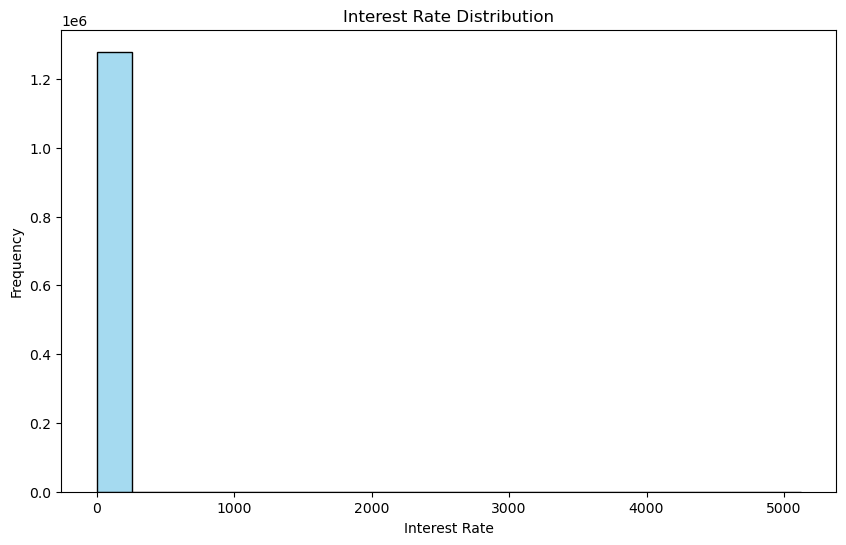

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(df['interest_rate'], bins=20, color='skyblue', edgecolor='black')
plt.title("Interest Rate Distribution")
plt.xlabel("Interest Rate")
plt.ylabel("Frequency")
plt.show()

In [35]:
df['interest_rate'] = df['interest_rate'].astype(float)
df['interest_rate'].value_counts().hvplot.bar(
    title='Bar Graph for interest_rate',
    xlabel='interest_rate',
    ylabel='Population [100,000]',
    rot=90,
    width=1000,
    height=600
)

:Bars   [interest_rate]   (count)

In [36]:
df['derived_ethnicity'].value_counts().hvplot.bar(
    title='Bar Graph for derived_ethnicity',
    xlabel='Ethnicity',
    ylabel='Population [100,000]',
    rot=90,
    width=600,  # Set the width of the plot
    height=400  # Set the height of the plot
)

:Bars   [derived_ethnicity]   (count)

In [37]:
df['derived_race'].value_counts().hvplot.bar(
    title='Bar Graph for derived_race',
    xlabel='Race',
    ylabel='Population [100,000]',
    rot=90,
    width=800,  # Set the width of the plot
    height=400  # Set the height of the plot
)

:Bars   [derived_race]   (count)

In [38]:
df['derived_sex'].value_counts().hvplot.bar(
    title='Bar Graph for derived_sex',
    xlabel='Sex of head of house',
    ylabel='Population [100,000]',
    rot=90,
    width=600,
    height=300
)

:Bars   [derived_sex]   (count)

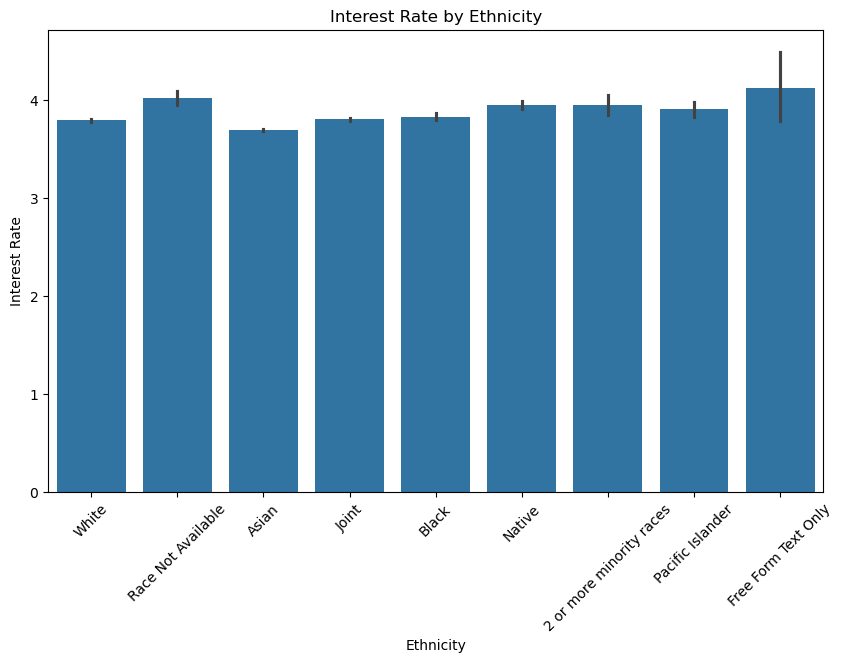

In [39]:
# Create a bar chart to compare interest rates by ethnicity
plt.figure(figsize=(10, 6))
sns.barplot(x='derived_race', y='interest_rate', data=df)
plt.title("Interest Rate by Ethnicity")
plt.xlabel("Ethnicity")
plt.ylabel("Interest Rate")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

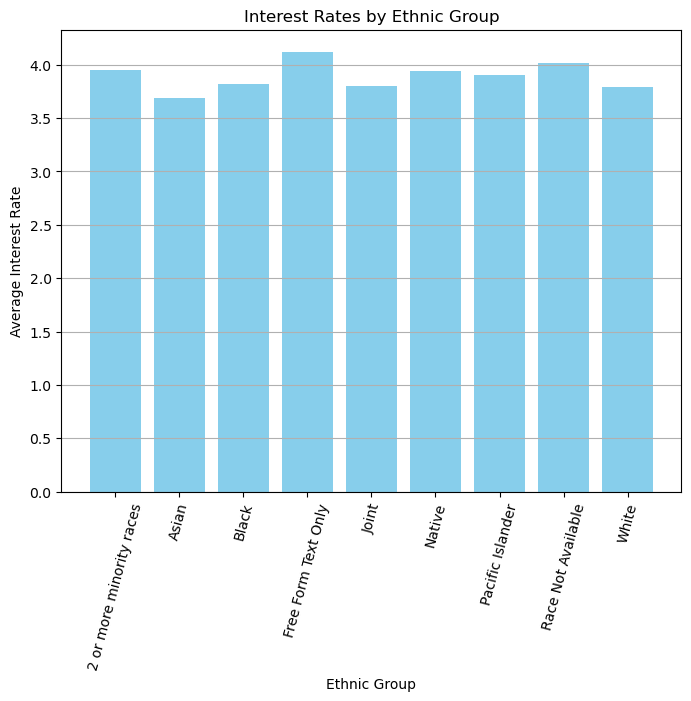

Ethnic group with highest interest rate: Free Form Text Only
Highest average interest rate: 4.12%
Ethnic group with lowest interest rate: Asian
Lowest average interest rate: 3.69%


In [40]:
# Group by ethnic group and calculate the average interest rate
interest_by_ethnicity = df.groupby("derived_race")["interest_rate"].mean()

# Identify the ethnic group with the highest average interest rate
highest_interest_ethnicity = interest_by_ethnicity.idxmax()
highest_interest_rate = interest_by_ethnicity.max()

# Identify the ethnic group with the lowest average interest rate
lowest_interest_ethnicity = interest_by_ethnicity.idxmin()
lowest_interest_rate = interest_by_ethnicity.min()

# Create a bar chart to visualize interest rates by ethnic group
plt.figure(figsize=(8, 6))
plt.bar(interest_by_ethnicity.index, interest_by_ethnicity.values, color="skyblue")
plt.xlabel("Ethnic Group")
plt.ylabel("Average Interest Rate")
plt.title("Interest Rates by Ethnic Group")
plt.xticks(rotation=75)
plt.grid(axis="y")
plt.show()

print(f"Ethnic group with highest interest rate: {highest_interest_ethnicity}")
print(f"Highest average interest rate: {highest_interest_rate:.2f}%")

print(f"Ethnic group with lowest interest rate: {lowest_interest_ethnicity}")
print(f"Lowest average interest rate: {lowest_interest_rate:.2f}%")

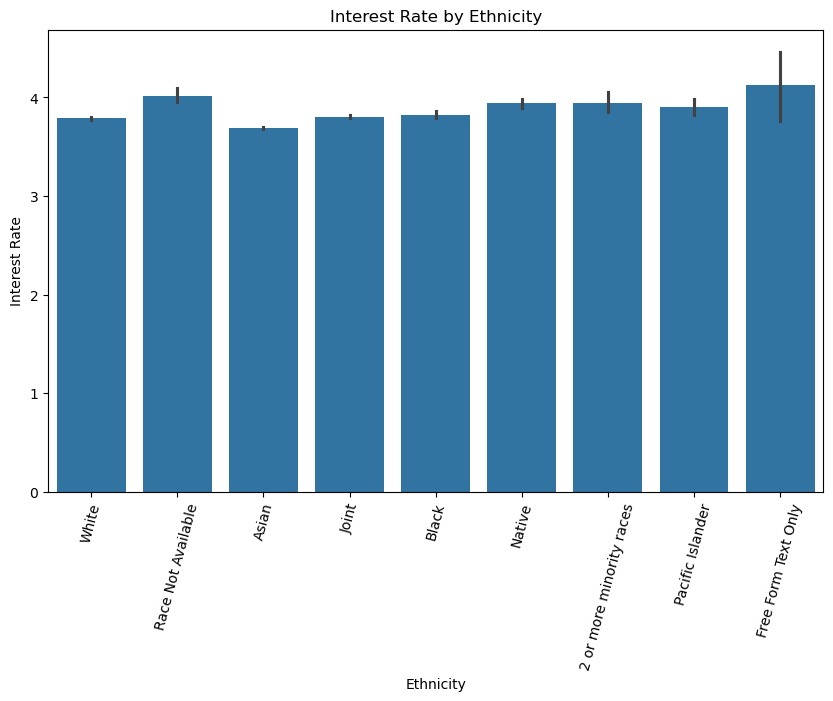

In [41]:
# Create a bar chart to compare interest rates by ethnicity
plt.figure(figsize=(10, 6))
sns.barplot(x='derived_race', y='interest_rate', data=df)
plt.title("Interest Rate by Ethnicity")
plt.xlabel("Ethnicity")
plt.ylabel("Interest Rate")
plt.xticks(rotation=75)  # Rotate x-axis labels for readability
plt.show()

### Scatter Plots

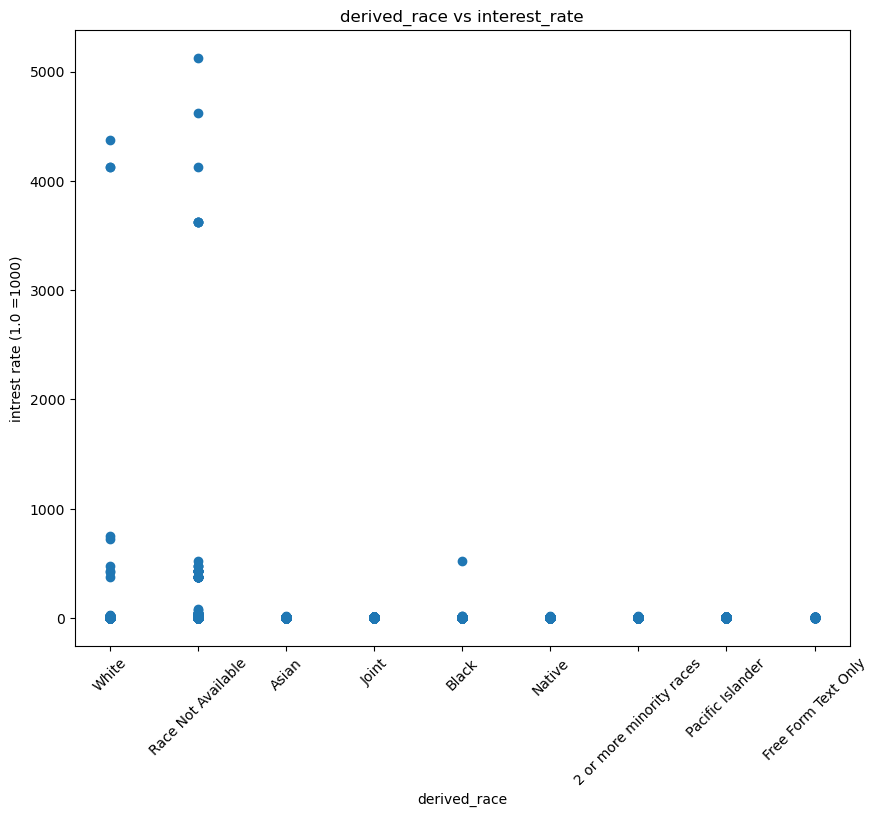

In [42]:
#Brivate and Correlation
plt.figure(figsize=(10, 8))
plt.scatter(df['derived_race'], df['interest_rate'])
plt.title('derived_race vs interest_rate')
plt.xlabel('derived_race')
plt.ylabel('intrest rate (1.0 =1000)')
plt.xticks(rotation=45)  # Rotate the x-label by 45 degrees
plt.show()

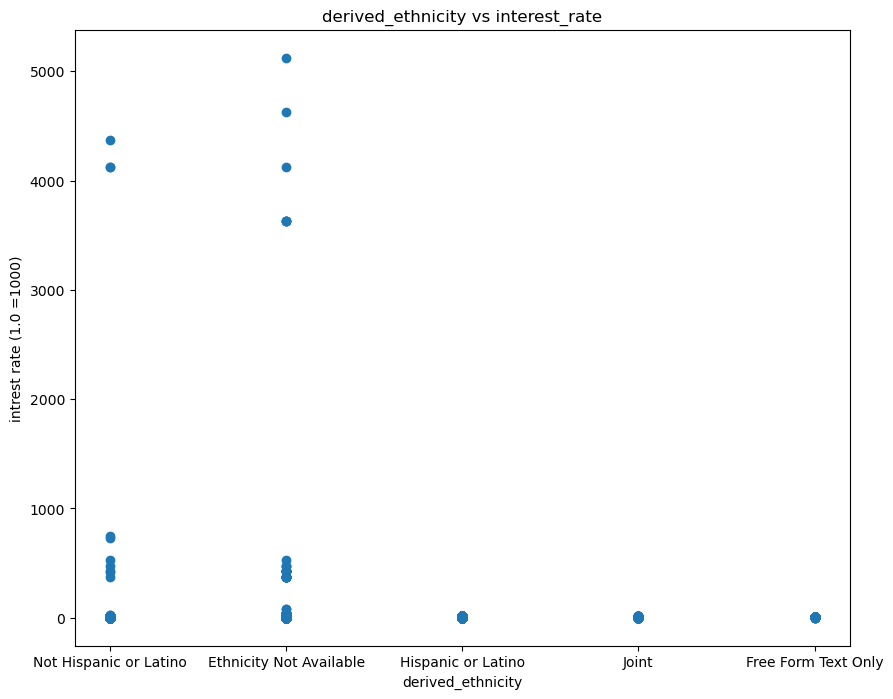

In [43]:
plt.figure(figsize=(10, 8))
plt.scatter(df['derived_ethnicity'], df['interest_rate'])
plt.title('derived_ethnicity vs interest_rate')
plt.xlabel('derived_ethnicity')
plt.ylabel('intrest rate (1.0 =1000)')
plt.show()

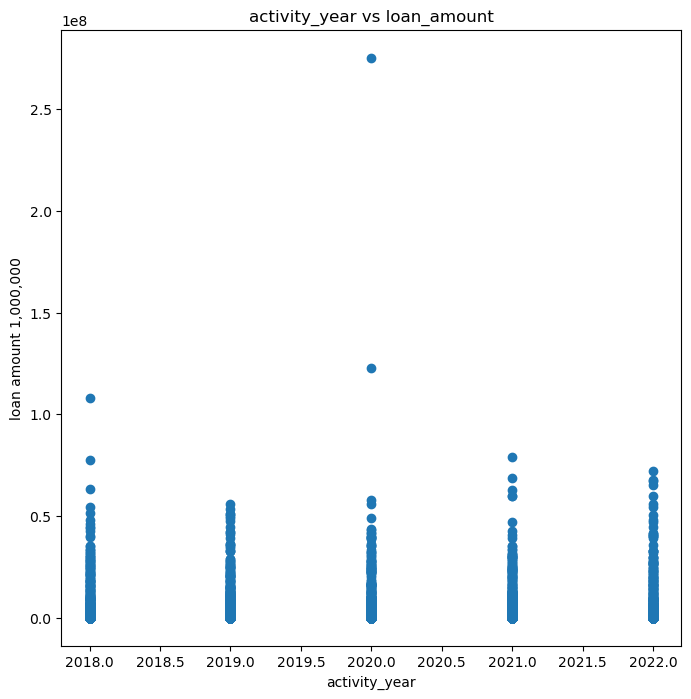

Correlation between intrest_rate and tract_population: 0.025783631753125962


In [44]:
plt.figure(figsize=(8, 8))
plt.scatter(df['activity_year'], df['loan_amount'])
plt.title('activity_year vs loan_amount')
plt.xlabel('activity_year')
plt.ylabel('loan amount 1,000,000')
plt.show()

# Calculate correlation
correlation = df['loan_amount'].corr(df['activity_year'])
print(f"Correlation between intrest_rate and tract_population: {correlation}")
plt.show()

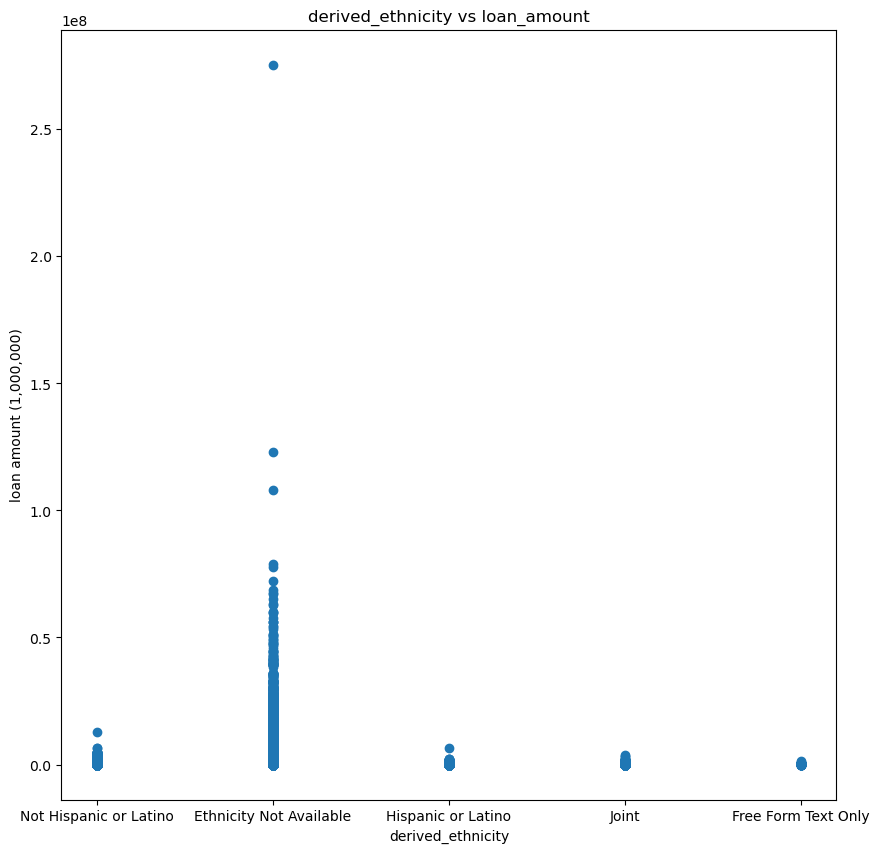

In [45]:
plt.figure(figsize=(10, 10))
plt.scatter(df['derived_ethnicity'], df['loan_amount'])
plt.title('derived_ethnicity vs loan_amount')
plt.xlabel('derived_ethnicity')
plt.ylabel('loan amount (1,000,000)')
plt.show()

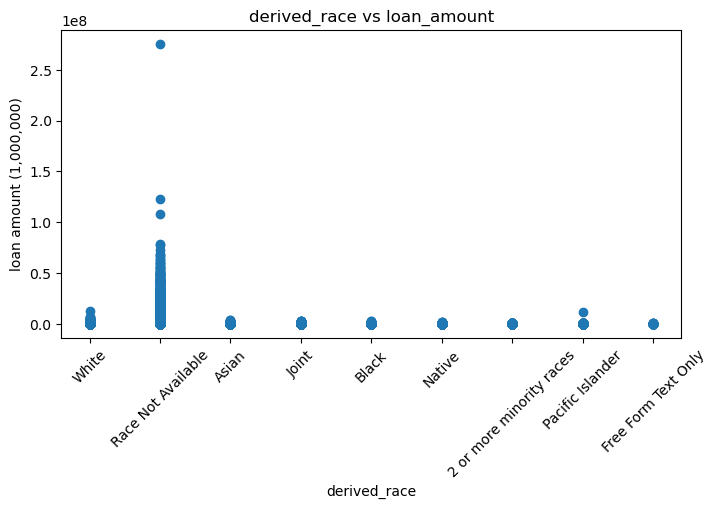

In [46]:
plt.figure(figsize=(8, 4))
plt.scatter(df['derived_race'], df['loan_amount'])
plt.title('derived_race vs loan_amount')
plt.xlabel('derived_race')
plt.ylabel('loan amount (1,000,000)')
plt.xticks(rotation=45)
plt.show()

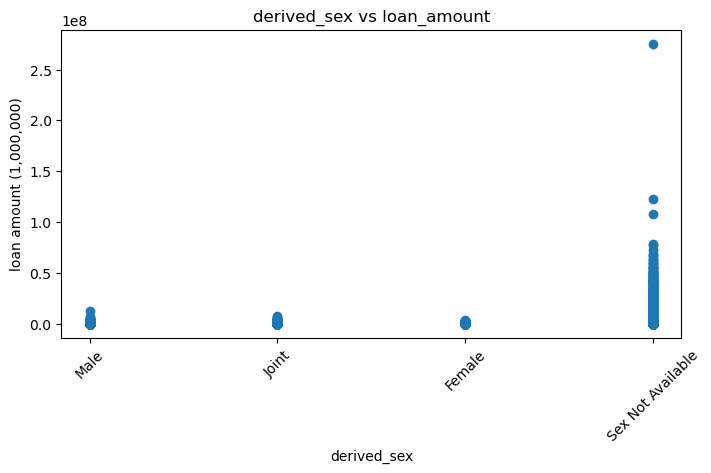

In [47]:
plt.figure(figsize=(8, 4))
plt.scatter(df['derived_sex'], df['loan_amount'])
plt.title('derived_sex vs loan_amount')
plt.xlabel('derived_sex')
plt.ylabel('loan amount (1,000,000)')
plt.xticks(rotation=45)
plt.show()

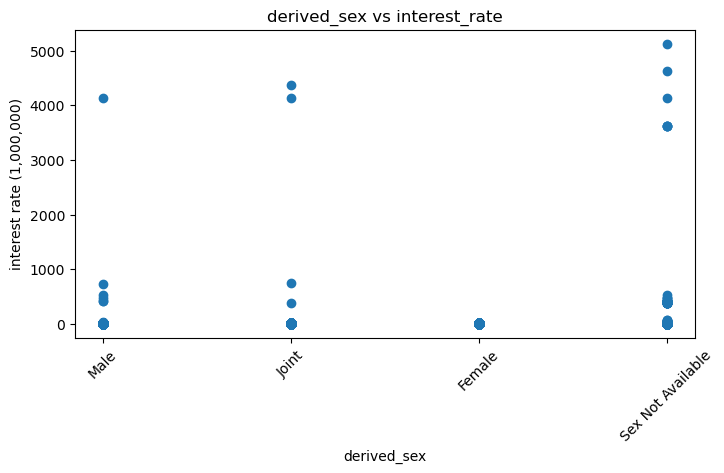

In [48]:
plt.figure(figsize=(8, 4))
plt.scatter(df['derived_sex'], df['interest_rate'])
plt.title('derived_sex vs interest_rate')
plt.xlabel('derived_sex')
plt.ylabel('interest rate (1,000,000)')
plt.xticks(rotation=45)
plt.show()

### Box Plots

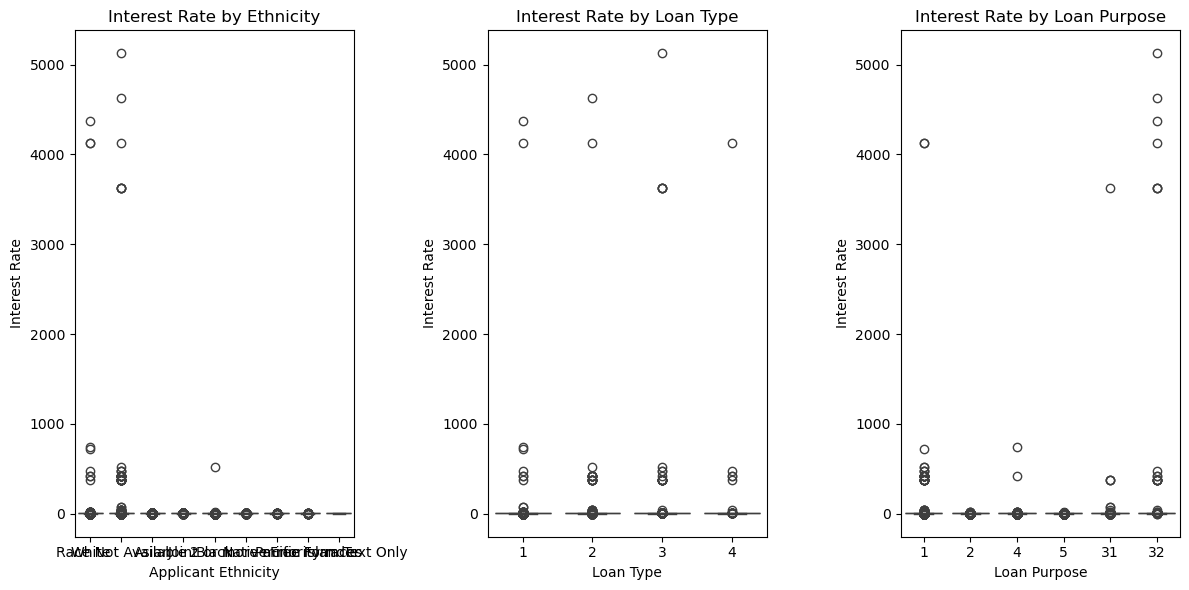

In [49]:
# Explore interest rate variations by customer segments (e.g., ethnicity, loan type, purpose)
plt.figure(figsize=(12, 6))

# Box plot by ethnicity
plt.subplot(1, 3, 1)
sns.boxplot(x='derived_race', y='interest_rate', data=df)
plt.title("Interest Rate by Ethnicity")
plt.xlabel("Applicant Ethnicity")
plt.ylabel("Interest Rate")

# Box plot by loan type
plt.subplot(1, 3, 2)
sns.boxplot(x='loan_type', y='interest_rate', data=df)
plt.title("Interest Rate by Loan Type")
plt.xlabel("Loan Type")
plt.ylabel("Interest Rate")

# Box plot by loan purpose
plt.subplot(1, 3, 3)
sns.boxplot(x='loan_purpose', y='interest_rate', data=df)
plt.title("Interest Rate by Loan Purpose")
plt.xlabel("Loan Purpose")
plt.ylabel("Interest Rate")

plt.tight_layout()
plt.show()

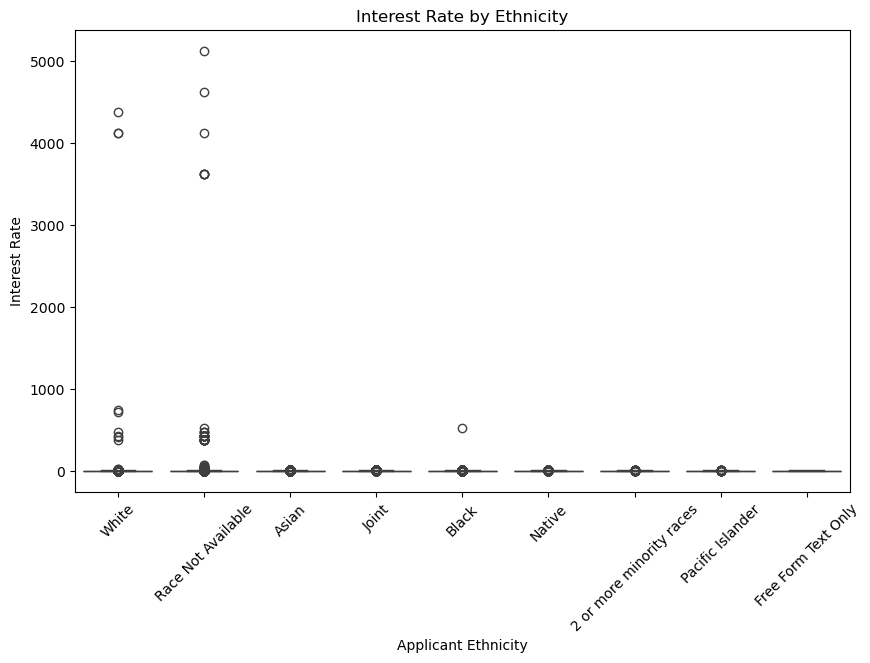

In [50]:
# Create a box plot to compare interest rates by ethnicity
plt.figure(figsize=(10, 6))
sns.boxplot(x='derived_race', y='interest_rate', data=df)
#sns.barplot(x='ethnicity', y='interest_rate', data=df)
plt.title("Interest Rate by Ethnicity")
plt.xlabel("Applicant Ethnicity")
plt.ylabel("Interest Rate")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

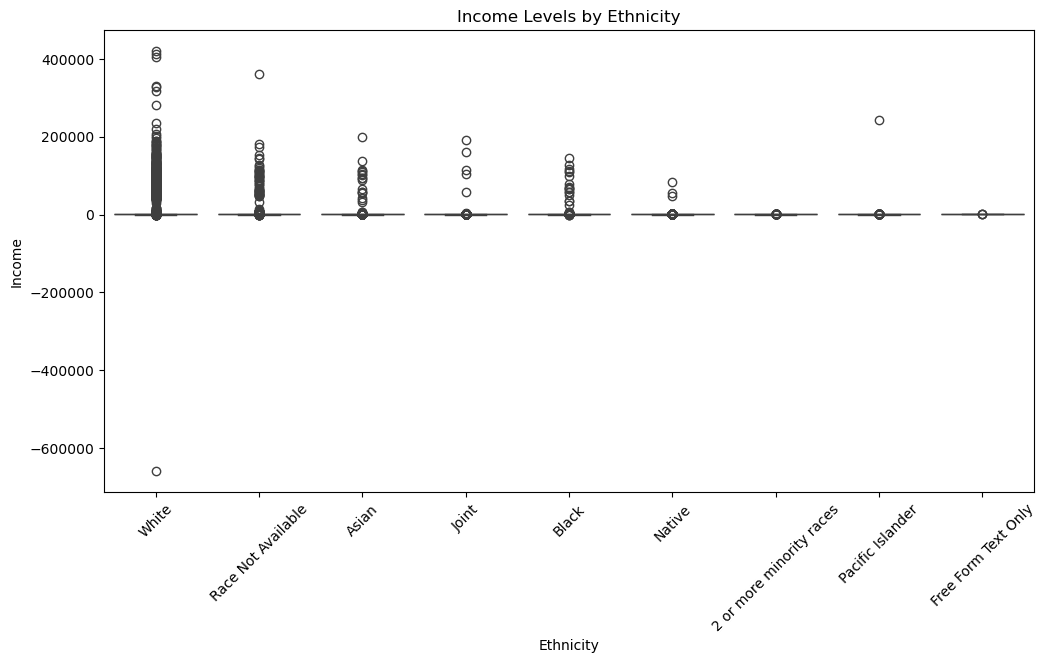

In [51]:
# 1. Economic Factors
# Explore income levels, credit scores, and employment status by ethnicity
plt.figure(figsize=(12, 6))
sns.boxplot(x='derived_race', y='income', data=df)
plt.title("Income Levels by Ethnicity")
plt.xlabel("Ethnicity")
plt.ylabel("Income")
plt.xticks(rotation=45)
plt.show()

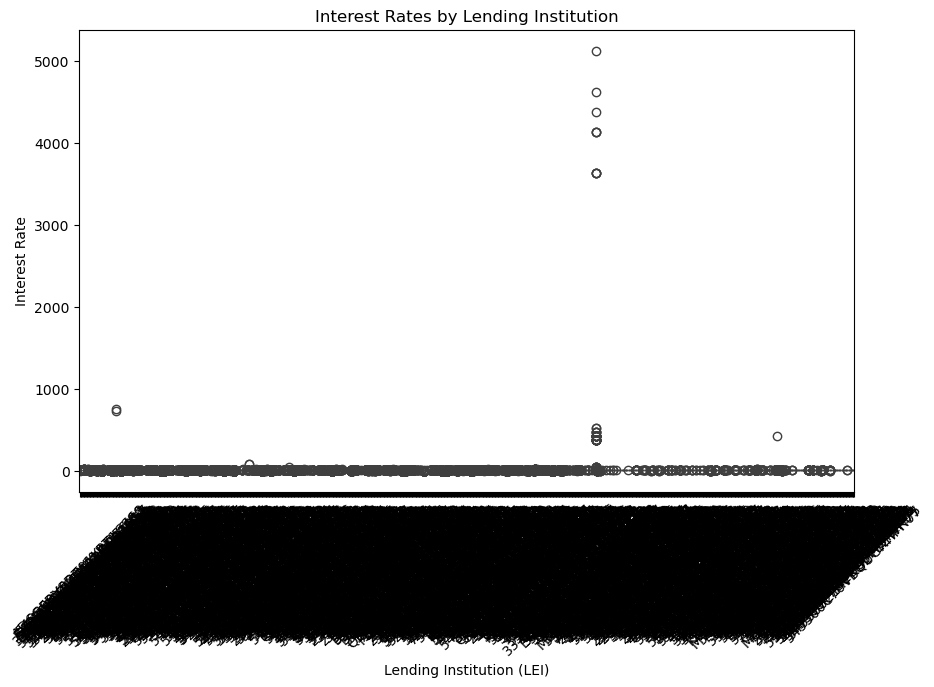

In [52]:
# 2. Lending Practices
# Investigate interest rates by lending institution (LEI)
plt.figure(figsize=(10, 6))
sns.boxplot(x='lei', y='interest_rate', data=df)
plt.title("Interest Rates by Lending Institution")
plt.xlabel("Lending Institution (LEI)")
plt.ylabel("Interest Rate")
plt.xticks(rotation=45)
plt.show()

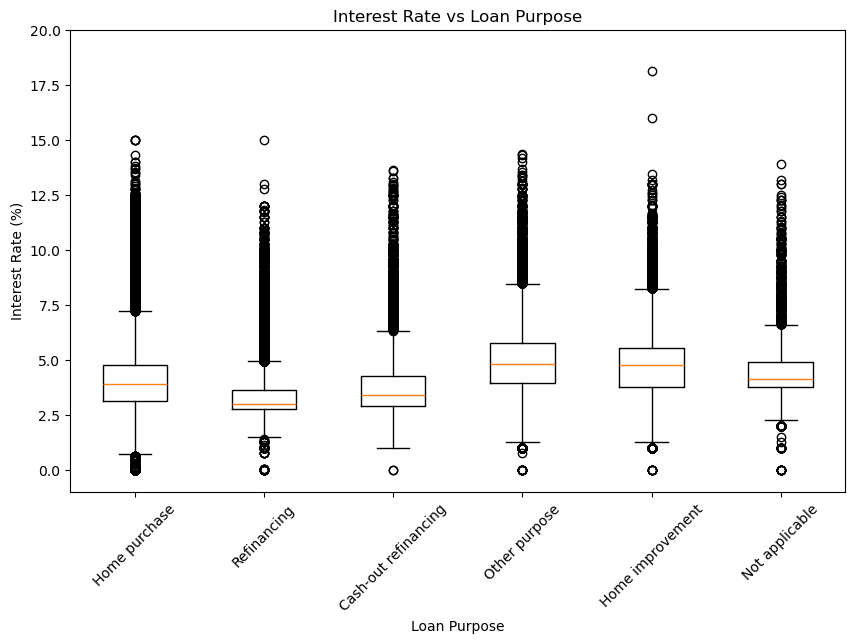

In [53]:
# Create a list of labels using the dictionary
labels = [label_dict[number] for number in df['loan_purpose'].unique()]
# Create a box plot
plt.figure(figsize=(10, 6))
plt.boxplot([df[df['loan_purpose'] == purpose]['interest_rate'] for purpose in df['loan_purpose'].unique()], labels=labels)
plt.title('Interest Rate vs Loan Purpose')
plt.xlabel('Loan Purpose')
plt.ylabel('Interest Rate (%)')
plt.xticks(rotation=45)  # Rotate the x-label by 45 degrees
# create a "window" over the data ... restrict the data points that actually show up on the plot visualization
# if this is not done then the y-axis becomes too dense , and the "box"s become so small that they are undecernible
plt.ylim(-1, 20)  # interest_rate values between -1% and 20% will show up on the plot visualization
plt.show()

### Findings      

In our analysis of mortgage data, we focused on interest rates and demographic characteristics. Here are the key findings:

Interest Rates Distribution:
- The majority of interest rates fall within the range of 0% to 8%.
- This distribution provides an overview of the prevailing interest rate landscape.

Demographic Breakdown:
- White mortgage owners constitute the largest group, with a total of 882,643 individuals.
- Other racial groups follow, but none come close to the White population in terms of mortgage ownership.

Ownership Types and Interest Rates:
- Joint ownership is the most common form of mortgage ownership, with 498,530 cases.
- Interestingly, joint owners tend to have higher interest rates compared to other ownership types.
- Female mortgage owners are the least represented group, with 220,124 individuals.

Interest Rate Peaks:
- Among all racial groups, Whites exhibit the highest peaks in interest rates.
- Further investigation into the factors driving these differences would be valuable.

## Geographic Mapping
-----

In [16]:
def get_county_info(fips_code):
    typeString = type(fips_code)
    if fips_code in county_data:
        county_info = county_data[fips_code]
        county_name = county_info["county"]
        # state = county_info["state"]
        latitude = county_info["latitude"]
        longitude = county_info["longitude"]
        return county_name, latitude, longitude

    else:
        return None, None, None

In [17]:
# ##################
# #  '2018', '2019' data uses different county codes... and we haven't found a translation yet... so dropping data for those years
# ##################

# Define the list of valid years
valid_years = [2020, 2021, 2022]

# Filter rows where 'year' is in the list of valid years
map_df = df[df['activity_year'].isin(valid_years)].copy()

In [18]:
# only two columns are of interest
clean_df = map_df[["county_code", "interest_rate"]].copy()

# remove rows where 'interest_rate' is not numeric
clean_df['interest_rate'] = pd.to_numeric(clean_df['interest_rate'], errors='coerce')

# Drop rows with NaN values in any column
clean_df = clean_df.dropna()

In [19]:
# Group by 'county_code' ... and calculate the mean of 'interest_rate' for each group
mean_interest_rate_by_county = clean_df.groupby('county_code')['interest_rate'].mean()

# Convert the result to a DataFrame for better readability
mean_interest_rate_by_county_df = mean_interest_rate_by_county.reset_index()

# Rename the 'interest_rate' column to 'mean_interest_rate'
mean_interest_rate_by_county_df = mean_interest_rate_by_county_df.rename(columns={'interest_rate': 'mean_interest_rate'})

for index, row in mean_interest_rate_by_county_df.iterrows():
    county_code = row['county_code']
    print(county_code)
    
    # Call get_county_info function to get latitude, longitude, county_name for county_code
    county_name, latitude, longitude = get_county_info(county_code)
    print(county_name, latitude, longitude)
    
    # Update 'lat', 'lon', 'county_name' columns fetched values
    mean_interest_rate_by_county_df.at[index, 'lat'] = latitude
    mean_interest_rate_by_county_df.at[index, 'lon'] = longitude
    mean_interest_rate_by_county_df.at[index, 'county_name'] = county_name

27001.0
Aitkin County 46.6742 -93.4087
27003.0
Anoka County 45.3311 -93.2778
27005.0
Becker County 46.9818 -95.7989
27007.0
Beltrami County 47.9439 -94.8502
27009.0
Benton County 45.6859 -94.0297
27011.0
Big Stone County 45.4219 -96.4086
27013.0
Blue Earth County 44.0601 -94.1017
27015.0
Brown County 44.2388 -94.7238
27017.0
Brown County 44.2388 -94.7238
27019.0
Carver County 44.8223 -93.7808
27021.0
Clearwater County 47.5738 -95.3641
27023.0
Carlton County 46.5567 -92.4995
27025.0
Chippewa County 45.0386 -95.5472
27027.0
Clay County 46.9016 -96.4115
27029.0
Clearwater County 47.5738 -95.3641
27031.0
Cook County 47.9349 -90.4108
27033.0
Cook County 47.9349 -90.4108
27035.0
Cottonwood County 43.8877 -95.2054
27037.0
Crow Wing County 46.5396 -94.0643
27039.0
Dakota County 44.6764 -93.0623
27041.0
Dodge County 44.0193 -92.8542
27043.0
Faribault County 43.6767 -93.9497
27045.0
Fillmore County 43.6318 -92.2454
27047.0
Freeborn County 43.6883 -93.3484
27049.0
Grant County 45.9657 -96.0174
27

/tmp/ipykernel_15187/2847630227.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Aitkin County' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  mean_interest_rate_by_county_df.at[index, 'county_name'] = county_name


In [20]:
mn_map_plot = mean_interest_rate_by_county_df.hvplot.points(
    "lon",
    "lat",
    geo  = True,
    tiles = "OSM",                                           # Set the background map image
    title = "Mean Interest Rate (%) by Minnesota County",    # Set the title of the plot
    width  = 600,
    height = 600,
    fontsize = 15,

    color = "mean_interest_rate",
    cmap = ["darkgreen", "green", "red", "darkred"],    # Set the colormap as a list of colors
    
    size="mean_interest_rate",                          # Set the size of each dot based on mean_interest_rate
    scale=5,

    hover_cols=["county_name","county_code"]
)

# Display the map plot
mn_map_plot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [lon,lat]   (mean_interest_rate,county_name,county_code)

## Questions
-----